# Прогнозирование методом линейной регрессии

**Данные:** Chicago_hotels, столбец таблицы x3

**Задание:** Построить прогноз на 8 месяцев. Коэффициент загрузки гостиниц в процентах (Hotel Occupancy (in %))
Данные для Chicago Central Business District Hotel Statistics. Предоставлены средние значения процента занятых номеров за один день. Усреднение по отелям и по дням месяца.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('Chicago_hotels.csv', sep=';', decimal=',')
df

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04","51,9","72,15"
1,February,1994,"54,7","102,74","60,1","73,47"
2,March,1994,"61,9","105,23",65,"74,91"
3,April,1994,"69,1","113,63","69,8","79,06"
4,May,1994,"70,8","120,77","72,4","82,07"
...,...,...,...,...,...,...
115,August,2003,,,,
116,September,2003,,,,
117,October,2003,,,,
118,November,2003,,,,


В таблицы "Chicago_hotels" в столбцах с числовыми значениями стоят запятые. Нужно заменить на точки.

In [5]:
# заменяет запятые на точки в столбце "х3"

df['x3']=df['x3'].str.replace(',','.')
df

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04",51.9,"72,15"
1,February,1994,"54,7","102,74",60.1,"73,47"
2,March,1994,"61,9","105,23",65,"74,91"
3,April,1994,"69,1","113,63",69.8,"79,06"
4,May,1994,"70,8","120,77",72.4,"82,07"
...,...,...,...,...,...,...
115,August,2003,,,,
116,September,2003,,,,
117,October,2003,,,,
118,November,2003,,,,


В столбце "х3" посление значения - пустые

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date1   120 non-null    object
 1   date2   120 non-null    int64 
 2   x1      120 non-null    object
 3   x2      120 non-null    object
 4   x3      120 non-null    object
 5   x4      120 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.8+ KB


Данная информация говорит о том, что все строки столбца "х3" заполнены и имеют тип данных object

In [7]:
# проверим что в столбце х3 и строке 117

df.x3[117]

' '

Видимо в последних строка спрятались пробелы. С помощью условия try заменим все числовы значения столбца "х3" на тип данных float, а пропуски на Nan

In [8]:
for idx, data in enumerate(df.x3):
    try:
        df.x3[idx] = float(df.x3[idx])
    except:
        df.x3[idx] = np.nan

In [9]:
# проверяем что получилось

df.x3

0      51.9
1      60.1
2      65.0
3      69.8
4      72.4
       ... 
115     NaN
116     NaN
117     NaN
118     NaN
119     NaN
Name: x3, Length: 120, dtype: object

In [10]:
# удаляем строки со значением Nan

df = df.dropna()
df

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04",51.9,"72,15"
1,February,1994,"54,7","102,74",60.1,"73,47"
2,March,1994,"61,9","105,23",65.0,"74,91"
3,April,1994,"69,1","113,63",69.8,"79,06"
4,May,1994,"70,8","120,77",72.4,"82,07"
...,...,...,...,...,...,...
107,December,2002,"54,8","148,95",46.6,"99,1"
108,January,2003,"51,6","132,89",45.3,"92,88"
109,February,2003,"52,7","127,44",50.8,"90,99"
110,March,2003,65,"147,32",55.9,"99,62"


Теперь с данными можно работать и строить графики.

Построим график загруженности гостиниц.

График имеет линейный тренд и аддитивную сезонность. Нет пропусков, график не меняет свой характер, возможно есть выбросы в райне 75-80. Какой-то год заполненность была выше, но в остальном явняй тренд на спад.

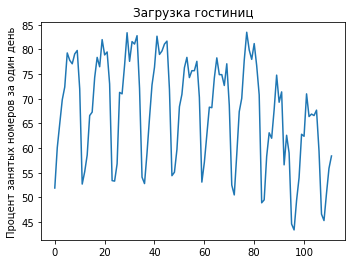

In [11]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['x3'].plot(ax=ax1)
ax1.set_title('Загрузка гостиниц')
ax1.set_ylabel('Процент занятых номеров за один день')
plt.show()

Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). Тем самым мы зададим линейный тренд

In [12]:
df['month_num'] = range(1, len(df) + 1)

In [13]:
df.head()

,date1,date2,x1,x2,x3,x4,month_num
0,January,1994,"44,3","104,04",51.9,"72,15",1
1,February,1994,"54,7","102,74",60.1,"73,47",2
2,March,1994,"61,9","105,23",65.0,"74,91",3
3,April,1994,"69,1","113,63",69.8,"79,06",4
4,May,1994,"70,8","120,77",72.4,"82,07",5


In [14]:
# эти переменные в модели не нужны

df_2 = df.drop(columns=['date1', 'date2', 'x1', 'x2', 'x4'])

Создадим новые переменные - индикаторы месяцев. Создаем строки за запасом, а затем отрезаем лишние

In [15]:
df_2["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*10)[0:len(df_2)]
df_2["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*10)[0:len(df_2)]
df_2["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*10)[0:len(df_2)]
df_2["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*10)[0:len(df_2)]
df_2["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*10)[0:len(df_2)]
df_2["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*10)[0:len(df_2)]

In [16]:
df_2.head(14)

,x3,month_num,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,51.9,1,1,0,0,0,0,0,0,0,0,0,0,0
1,60.1,2,0,1,0,0,0,0,0,0,0,0,0,0
2,65.0,3,0,0,1,0,0,0,0,0,0,0,0,0
3,69.8,4,0,0,0,1,0,0,0,0,0,0,0,0
4,72.4,5,0,0,0,0,1,0,0,0,0,0,0,0
5,79.3,6,0,0,0,0,0,1,0,0,0,0,0,0
6,77.8,7,0,0,0,0,0,0,1,0,0,0,0,0
7,77.1,8,0,0,0,0,0,0,0,1,0,0,0,0
8,79.1,9,0,0,0,0,0,0,0,0,1,0,0,0
9,79.8,10,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
#  Создаем таблицу (столбец) откликов

y = df_2['x3']

In [18]:
#  Создаем матрицу предикторов.
#  Убираем из нее отклик и столбец индикаторов базового месяца

X = df_2.drop(columns=['x3', 'm01'])

In [19]:
#  Подгонка модели

model = LinearRegression()
model.fit(X, y)

LinearRegression()

Посмотрим на коэффициенты модели

In [20]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,57.138035
1,month_num,-0.104146
2,m02,6.104146
3,m03,13.408292
4,m04,16.232438
5,m05,21.537263
6,m06,27.352521
7,m07,23.667778
8,m08,25.060813
9,m09,23.576070


По коэффициентам самая высокая загруженность отелей в июне, а самая низкая - в январе, так как все коэфициенты больше относительного января. Возможно, это вызвано празднованием Нового года и Рождества, когда меньше людей работает и останавливается в отелях в командировках, когда многие собираются дома семьями.

In [21]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

К коэффициентам модели добавим проверку гипотез о равенстве этих коэффициентов нулю.

In [22]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,57.138035,0.000000e+00
1,month_num,-0.104146,2.220446e-15
2,m02,6.104146,5.904407e-04
3,m03,13.408292,4.254597e-12
4,m04,16.232438,8.881784e-16
5,m05,21.537263,0.000000e+00
6,m06,27.352521,0.000000e+00
7,m07,23.667778,0.000000e+00
8,m08,25.060813,0.000000e+00
9,m09,23.576070,0.000000e+00


<AxesSubplot:>

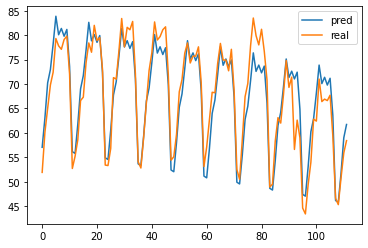

In [23]:
#  Сравним подгонку и исходный ряд

pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

Значения подгонки достаточно близки к реальным значениям. Кроме значений похожих на выбросы в районе 75-80.

In [24]:
#  Все хорошо?
pred.head(14)

,pred,real
0,57.033889,51.9
1,63.033889,60.1
2,70.233889,65.0
3,72.953889,69.8
4,78.154568,72.4
5,83.865679,79.3
6,80.076790,77.8
7,81.365679,77.1
8,79.776790,79.1
9,81.165679,79.8


In [25]:
#  Готовим матрицу значений предикторов df_3 
#  для вычисления прогнозов на 8 месяцев вперед
#  Сначала добавляем в нее время (номер месяца)

df_3 = pd.DataFrame()

df_3['month_num'] = range(len(df)+1, len(df)+9)

In [26]:
df_3.head()

,month_num
0,113
1,114
2,115
3,116
4,117


In [27]:
#  Добавляем индикаторы месяцев. Базового месяца не должно быть

#df_3["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0])[0: 8 ]
df_3["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0])[0: 8 ]
df_3["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0])[0: 8 ]
df_3["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0])[0: 8 ]
df_3["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0])[0: 8 ]
df_3["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0])[0: 8 ]
df_3["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0])[0: 8 ]
df_3["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1])[0: 8 ]

In [28]:
df_3.head(8)

,month_num,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,113,0,0,0,0,0,0,0,0,0,0,0
1,114,1,0,0,0,0,0,0,0,0,0,0
2,115,0,1,0,0,0,0,0,0,0,0,0
3,116,0,0,1,0,0,0,0,0,0,0,0
4,117,0,0,0,1,0,0,0,0,0,0,0
5,118,0,0,0,0,1,0,0,0,0,0,0
6,119,0,0,0,0,0,1,0,0,0,0,0
7,120,0,0,0,0,0,0,1,0,0,0,0


In [29]:
#  Предикторы готовы, можно вычислить прогноз для исходного ряда

model.predict(df_3)

array([45.36952675, 51.36952675, 58.56952675, 61.28952675, 66.49020576,
       72.20131687, 68.41242798, 69.70131687])

In [30]:
#  Матрица с подгонкой

pred['forecast'] = np.nan
pred.head()

,pred,real,forecast
0,57.033889,51.9,NaN
1,63.033889,60.1,NaN
2,70.233889,65.0,NaN
3,72.953889,69.8,NaN
4,78.154568,72.4,NaN


In [31]:
#  Продолжение предыдущей матрицы. 
#  Оно содержит спрогнозированные значения для месяцев с 113-ого по 120-ый.
#  Для этих месяцев есть спрогнозированные значения, 
#  но нет исторических и подгонки.

pred_2 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
pred_2['real'] = np.nan
pred_2['pred'] = np.nan

In [32]:
pred_2.head()

,forecast,real,pred
0,45.369527,NaN,NaN
1,51.369527,NaN,NaN
2,58.569527,NaN,NaN
3,61.289527,NaN,NaN
4,66.490206,NaN,NaN


<AxesSubplot:>

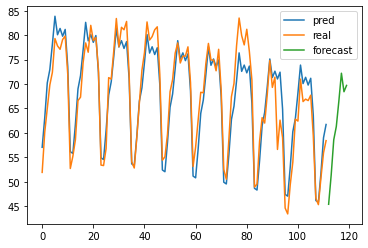

In [33]:
#  объединяем матрицы, задаем новые индексы

pred_3 = pd.concat(
    [pred, pred_2],
    sort=False
).reset_index(drop=True)

pred_3.plot()

**Вывод:** На графике выше представленно предсказание на 8 месяцев для исходного ряда. Это предсказание сформировалось из линейного тренда, который был задан. Предсказание очень похоже на последние два года.